In [1]:
# Imports

import os
import sys

sys.path.append("..")

from os import listdir
from os.path import isfile, join
import app.dvmg.patterns
import numpy as np
import json
import random
import inspect

import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.utils import to_categorical

In [2]:
# Get patterns list
patterns_list: list = inspect.getmembers(
        app.dvmg.patterns, inspect.isclass)
f_patterns_list: list = [
    ptrn for ptrn in patterns_list if ptrn[0] != 'PatternBase' and ptrn[0] != 'Custom']

print(f_patterns_list)

[('LinearDecrease', <class 'app.dvmg.patterns.builtin.LinearDecrease'>), ('LinearIncrease', <class 'app.dvmg.patterns.builtin.LinearIncrease'>), ('Normal', <class 'app.dvmg.patterns.builtin.Normal'>), ('NormalFlipped', <class 'app.dvmg.patterns.builtin.NormalFlipped'>), ('Plain', <class 'app.dvmg.patterns.builtin.Plain'>), ('Sigmoid', <class 'app.dvmg.patterns.builtin.Sigmoid'>), ('SigmoidReversed', <class 'app.dvmg.patterns.builtin.SigmoidReversed'>)]


In [5]:
# Create DataSet

onlyfiles = [f for f in listdir("../dataset/") if isfile(join("../dataset/", f))]

# Create empty dataset lists
dataset_model_1: list[tuple[tuple, str]] = list() # ((X,y), pattern_name)
test_dataset_model_1: list[tuple[tuple, str]] = list() # ((test_data_X,test_data_y), pattern_name)

dataset_model_2: list[tuple[np.ndarray, int]] = list() # (X, class_id)
test_dataset_model_2: list[tuple[np.ndarray, int]] = list() # (X, class_id)

# Paths to data files
training_file_path = f'../dataset/{onlyfiles[0]}'
# test_file_path = f'../dataset/{onlyfiles[1]}'

def parse(path: str, pattern_name: str) -> tuple[np.ndarray, np.ndarray, list]:

    X_model_2: list[tuple[np.ndarray, list]] = list() # Данные для обучения для полносвязной НС
    X_model_1 = np.empty((0, 16), int) # Данные для обучения (координаты реконструкции фазового портрета) до сортировки для перцептронов
    y_model_1 = np.array([]) # 1 - соответствует правильному паттерну, на который тренируется сеть, 0 - всем остальным до сортировки для перцептронов

    random_value = np.array([]) # Случайная величина для перемешивания датасета
    with open(path, 'r') as json_file:
        data: dict = json.load(json_file)
        
        for ptrn in list(data.keys()):
            all_coordinates: list = data[ptrn]
            
            for local_cordinates in all_coordinates:
                X_model_2.append(([np.append(np.array(local_cordinates['x']), np.array(local_cordinates['y'])).tolist()], list(data.keys()).index(ptrn))) # type: ignore
                X_model_1 = np.append(X_model_1, np.array([np.append(np.array(local_cordinates['x']), np.array(local_cordinates['y'])).tolist()]), axis=0)
                y_model_1 = np.append(y_model_1, 1) if ptrn == pattern_name else np.append(y_model_1, 0)
                random_value = np.append(random_value, np.random.rand()) # Генерация случайного числа от 0 до 1

    # Сортировка по случайным величинам
    return { # type: ignore
        "X_model_1": np.array([x for _, x, _ in sorted(zip(random_value, X_model_1, y_model_1), key=lambda x: x[0])]),
        "y_model_1": np.array([y for _, _, y in sorted(zip(random_value, X_model_1, y_model_1), key=lambda x: x[0])]),
        "X_model_2": [x for _, x in sorted(zip(random_value, X_model_2), key=lambda x: x[0])]
    }


for ptrn in f_patterns_list:

    pattern_name, signature = ptrn
    data = parse(training_file_path, pattern_name)

    X_model_1 = data["X_model_1"] # type: ignore
    y_model_1 = data["y_model_1"] # type: ignore
    X_model_2 = data["X_model_2"] # type: ignore

    dataset_model_1 += [((X_model_1, y_model_1), pattern_name)]
    dataset_model_2 = [*dataset_model_2, *X_model_2]

    # test_data = parse(test_file_path, pattern_name)

    # X_model_1 = test_data["X_model_1"] # type: ignore
    # y_model_1 = test_data["y_model_1"] # type: ignore
    # X_model_2 = test_data["X_model_2"] # type: ignore

    # test_dataset_model_1 += [((X_model_1, y_model_1), pattern_name)]
    # test_dataset_model_2 = [*test_dataset_model_2, *X_model_2]

# print(dataset_model_1[0])
# print('\n-----------------\n')
print(dataset_model_2[0])
print('\n-----------------\n')

# print(test_dataset_model_1[0])
# print('\n-----------------\n')
# print(test_dataset_model_2[0])
# print('\n-----------------\n')

# print(len(dataset_model_1))

x_train = list()
y_train = list()

for sample in dataset_model_2:
    x_train.append(sample[0][0])
    y_train.append(sample[1])

x_train = tf.convert_to_tensor(x_train)
y_train = to_categorical(y_train, 7)

print(x_train, y_train)  


KeyboardInterrupt: 

In [10]:
model = Sequential()
model.add(Input(shape=(14,)))
model.add(Dense(70, activation='sigmoid', name='hidden_1'))
model.add(Dense(32, activation='sigmoid', name='hidden_2'))
model.add(Dense(7, activation='softmax', name='output'))

model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=20, epochs=5)

Epoch 1/5
7350/7350 [==============================] - 12s 1ms/step - loss: 0.6079 - accuracy: 0.7814
Epoch 2/5
7350/7350 [==============================] - 11s 2ms/step - loss: 0.3396 - accuracy: 0.8621
Epoch 3/5
7350/7350 [==============================] - 13s 2ms/step - loss: 0.3254 - accuracy: 0.8663
Epoch 4/5
7350/7350 [==============================] - 14s 2ms/step - loss: 0.3190 - accuracy: 0.8677
Epoch 5/5
7350/7350 [==============================] - 13s 2ms/step - loss: 0.3164 - accuracy: 0.8686


1/1 [==============================] - 0s 64ms/step
ITER [1] TIME: 2022-12-08 12-16-32 LinearDecrease
1/1 [==============================] - 0s 26ms/step
ITER [2] TIME: 2022-12-08 12-31-32 LinearDecrease
1/1 [==============================] - 0s 31ms/step
ITER [3] TIME: 2022-12-08 12-46-32 LinearDecrease
1/1 [==============================] - 0s 23ms/step
ITER [4] TIME: 2022-12-08 13-01-32 LinearDecrease
1/1 [==============================] - 0s 23ms/step
ITER [5] TIME: 2022-12-08 13-16-32 LinearDecrease
1/1 [==============================] - 0s 20ms/step
ITER [6] TIME: 2022-12-08 13-31-32 LinearDecrease
1/1 [==============================] - 0s 23ms/step
ITER [7] TIME: 2022-12-08 13-46-32 LinearDecrease
1/1 [==============================] - 0s 21ms/step
ITER [8] TIME: 2022-12-08 14-01-32 Normal
1/1 [==============================] - 0s 28ms/step
ITER [9] TIME: 2022-12-08 14-16-32 LinearDecrease
1/1 [==============================] - 0s 26ms/step
ITER [10] TIME: 2022-12-08 14-31-32 Li

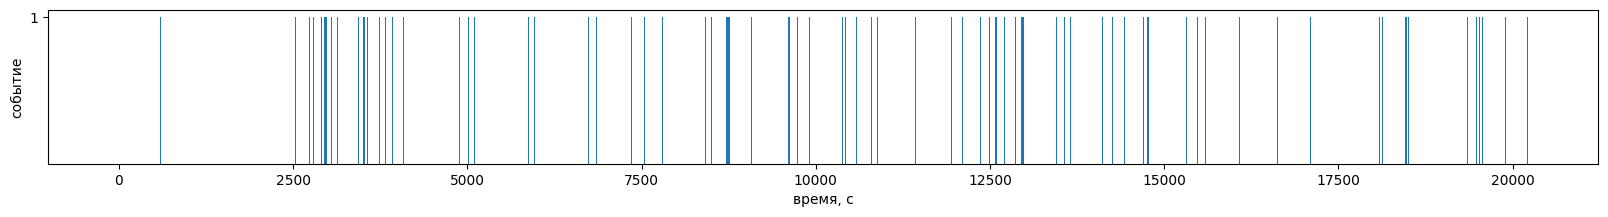

In [12]:
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

import sys, os
sys.path.insert(0, os.path.abspath('..'))
from app.utils import *

lines: list = open('./data/cameraDetections.txt').read().splitlines()

timestamps: list = list()

for line in lines:
    if '2021-' in line:
        continue
    if '+04' in line:
        line = line.replace('+04', '')
    if '.' not in line:
        line += '.0'
    time = datetime.strptime(line, '%Y-%m-%d %H:%M:%S.%f') - timedelta(hours=1)
    timestamps.append(time.timestamp())

dt_strings: list[str] = list()
dt_objects: list[datetime] = list()
for tmsp in timestamps:
    dt_strings += [datetime.fromtimestamp(tmsp).strftime('%Y-%m-%d %H:%M:%S.%f')]
    dt_objects += [datetime.fromtimestamp(tmsp)]

DEVIDER = 100

counter = 0
start_time = dt_objects[0] - timedelta(minutes=15)
end_time = start_time + timedelta(hours=6)
while end_time < dt_objects[-1]:
    counter += 1
    start_time = start_time + timedelta(minutes=15)
    end_time = start_time + timedelta(hours=6)

    to_inspect_timestamps: list[float] = [dt.timestamp() for dt in dt_objects if dt > start_time and dt <= end_time]
    to_inspect_timestamps_dt: list[str] = [dt.strftime('%Y-%m-%d %H:%M:%S.%f') for dt in dt_objects if dt > start_time and dt <= end_time]
    # print(to_inspect_timestamps_dt)

    output: dict = dict()
    cut_timestamp = [to_inspect_timestamps[i] - min(to_inspect_timestamps) + .001 for i in range(len(to_inspect_timestamps))]
    if len(cut_timestamp) == 0:
        continue

    for time in cut_timestamp:
        output[time] = 1
    # print(list(output.keys()))
    to_hist = process_coordinates_to_histogram(list(output.keys()), DEVIDER)
    x, y = compile_phase_portrait(to_hist, DEVIDER, 20)
    rx, ry = compile_phase_reconstruction_quantile(x, y)
    test_data = tf.convert_to_tensor(np.array(rx + ry), tf.float32)

    # Predict and print
    prediction = model.predict(tf.expand_dims(test_data, axis=0)) #type: ignore
    tt = start_time.strftime('%Y-%m-%d %H:%M:%S').replace(':','-')
    class_name = f_patterns_list[prediction.tolist()[0].index(max(prediction.tolist()[0]))][0]
    print(f"ITER [{counter}] TIME: {tt} " + class_name)
    plt.close('all')
    plt.rcParams["figure.figsize"] = [20, 2]
    plt.bar(list(output.keys()), list(output.values()), width=10)  # type: ignore
    plt.yticks([1])
    plt.xlabel("время, c")
    plt.ylabel("событие")
    plt.savefig(f'./images/events/{tt}+{class_name}.png')


# timestamps = timestamps[66:120] #78 #169
# timestamps = timestamps[78:190] #78 #169
